In [1]:
from local.lib import prepare_dataset as pre
from local.lib import models
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


## Metadata generator

In [18]:
metadata=pre.create_and_read_metadata()
metadata

,names,xmin,xmax,ymin,ymax,split,label
0,IMG_20200921_142309.jpg,0.35250,0.63875,0.283315,0.820693,train,0
1,IMG_20200921_142324.jpg,0.45850,0.69400,0.268689,0.703684,test,0
2,IMG_20200921_142337.jpg,0.49875,0.75450,0.360238,0.859155,train,0
3,IMG_20200921_142350.jpg,0.46775,0.68875,0.261647,0.720477,test,0
4,IMG_20200921_142359.jpg,0.50650,0.75975,0.314193,0.843445,train,0
...,...,...,...,...,...,...,...
504,IMG_20200923_140823.jpg,0.41375,0.79200,0.076381,0.868906,test,0
505,IMG_20200923_140830.jpg,0.45400,0.83875,0.183099,0.887324,train,0
506,IMG_20200923_140839.jpg,0.40775,0.85125,0.050921,0.934453,train,0
507,IMG_20200923_140847.jpg,0.44350,0.82500,0.092091,0.840195,train,0


## Generate train and test sources

In [3]:
train_sources = pre.build_sources_from_metadata(metadata)
test_sources = pre.build_sources_from_metadata(metadata, mode='test')

## Plot images from train including Bbox

In [4]:
dataset = pre.make_tf_dataset(test_sources,new_size=(300,300), batch_size=3, num_parallel_calls=3)
dataset = iter(dataset)

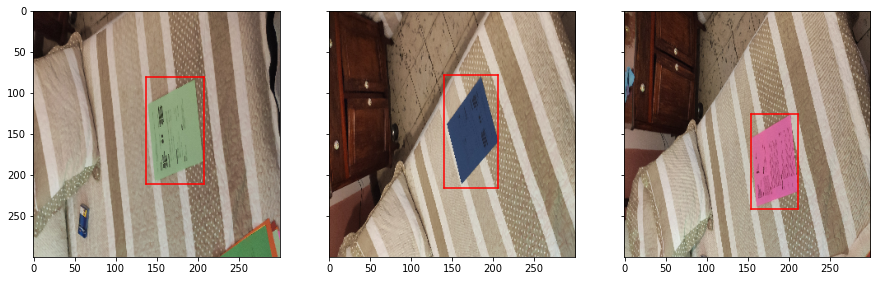

In [5]:
pre.imshow_batch_of_three(next(dataset),show_box=True)

## Instance Lenet CNN 

In [10]:
lenet=models.get_lenet()
lenet.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(0.0001))
lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                4

## create tf dataset for train and test

In [11]:
dataset = pre.make_tf_dataset(train_sources, training=True,batch_size=4, num_epochs=1,
                              new_size=(32,32),num_parallel_calls=2)

testset = pre.make_tf_dataset(train_sources, training=True,batch_size=1, num_epochs=1,
                              new_size=(32,32),num_parallel_calls=2)

## evaluate dataset with the CNN not trained

In [12]:
print(lenet.evaluate(dataset))

87/87 [==============================] - 16s 184ms/step - loss: 0.0797
0.0796672535696249


## fit model and generate history

In [13]:
#fit model and generate history

h=lenet.fit(x=dataset, epochs=10,validation_data=testset, validation_steps=1)

Train for 87 steps, validate for 1 steps
Epoch 1/10
87/87 [==============================] - 19s 217ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 2/10
87/87 [==============================] - 17s 201ms/step - loss: 0.0112 - val_loss: 0.0492
Epoch 3/10
87/87 [==============================] - 17s 196ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 4/10
87/87 [==============================] - 17s 190ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 5/10
87/87 [==============================] - 17s 191ms/step - loss: 0.0105 - val_loss: 0.0128
Epoch 6/10
87/87 [==============================] - 16s 183ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 7/10
87/87 [==============================] - 18s 203ms/step - loss: 0.0104 - val_loss: 0.0421
Epoch 8/10
87/87 [==============================] - 18s 205ms/step - loss: 0.0102 - val_loss: 0.0124
Epoch 9/10
87/87 [==============================] - 17s 193ms/step - loss: 0.0099 - val_loss: 0.0407
Epoch 10/10
87/87 [==============================]

## Plot loss

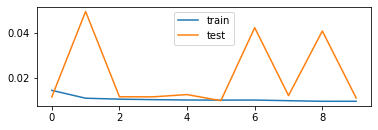

In [14]:
plt.subplot(2,1,1)
plt.plot(h.history['loss'],label='train')
plt.plot(h.history['val_loss'],label='test')
plt.legend()


## Generate dataset to plot predictions

In [15]:
#predict with model
predictions=lenet.predict(testset)

In [16]:
#generate sources for predictions
prediction_sources=pre.predicts_to_sources(test_sources,predictions)

#create TF dataset for prediction sourses to plot them

dataset = pre.make_tf_dataset(prediction_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)
dataset = iter(dataset)

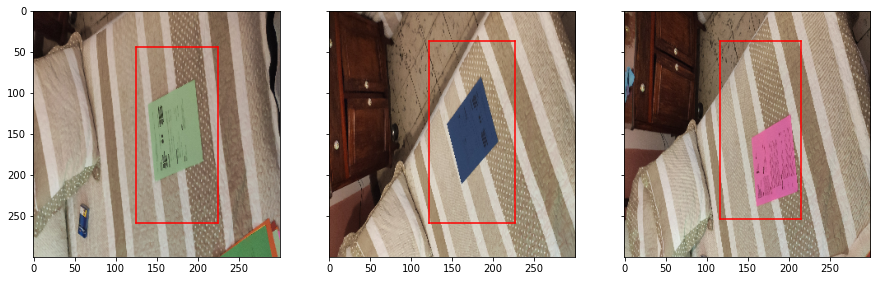

In [17]:
#plot predictions
pre.imshow_batch_of_three(next(dataset),show_box=True)



In [27]:
def IoU(Ytrue,Ypred):
    X=min(Ytrue[1],Ypred[1])-max(Ytrue[0],Ypred[0])
    Y=min(Ytrue[3],Ypred[3])-max(Ytrue[2],Ypred[2])
    
    if X<=0 or Y<=0:
        
        return 0
    
    I=X*Y
    U=((Ytrue[1]-Ytrue[0])*(Ytrue[3]-Ytrue[2])+(Ypred[1]-Ypred[0])*(Ypred[3]-Ypred[2]))-I
    IoU=I/U
    
    return IoU

In [29]:
a=[0.1,0.9,0.1,0.6]
b=[0.2,0.8,0.2,0.7]

print(IoU(b,a))



0.5217391304347827
[[0.1 0.9]] [[0.1 0.6]] [[0.2 0.8]] [[0.2 0.7]]
[-0.]
